# Solving 0-1 Knapsack Problem Using DEAP Framewok


[DEAP](https://deap.readthedocs.io/en/master/index.html) is a novel evolutionary computation framework for rapid prototyping and testing of ideas.

In 0-1 Knapsack Problem we have a bag of capacity `C` and we have a set of items, each item has a corresponding weight and profit and we want to select a subset of items in way that maximize the total profit while not exceeding the total capacity of the bag `C`.


In [1]:
!pip install deap
%matplotlib inline

first we import the required libraries.

In [2]:
from deap import creator, base, tools, algorithms
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


we load the dataset we are using the 8th dataset (can be found [here](http://people.sc.fsu.edu/~jburkardt%20/datasets/knapsack_01/knapsack_01.html)) of 24 item and total bag capacity 6404180.*italicized text*

In [3]:
C = 6404180
S = 24
MAX_PROFIT = 13549094
OPTIMAL_SOLUTION = [1,1,0,1,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,1,1,]
WEIGHTS = pd.read_csv('http://people.sc.fsu.edu/~jburkardt%20/datasets/knapsack_01/p08_w.txt', sep='\n', header=None)[0]
PROFITS = pd.read_csv('http://people.sc.fsu.edu/~jburkardt%20/datasets/knapsack_01/p08_p.txt', sep='\n', header=None)[0]


2. create two types using the `create` method of DEAP, this method takes three paramaters: the first one is the name of the new type, the second one is the base class of the new type and the remaining ones are any additional properties that are specific to the new type. The `FitnessMax`  type inherent from the class `base.Fitness` and has one requiered property `weight`, which is a tuple that determine whether we are maximizing (+1.0) or minimizing (-1.0) some objectives.

In [4]:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

The `Toolbox` is a tool that allow you to create an aliases for some function while providing values for some of its parameters. 

In [5]:
toolbox = base.Toolbox()

We represent each individual here as string of 0 or 1. all strings (individuals) have a length equal to the number of candidate items. Each ith gene (index in the string) is either equal to 1 which mean we are selecting that ith item and 0 mean we are not.

In [6]:
toolbox.register('pick', np.random.choice, (True,False))
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.pick, S)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)



Below we define our objective function which we are trying to maximize. The objective function which return the total profit of some individual. As our operators are random we may create an invalid indivduals, in this case this function should return constant value of 0 which specify the minimum profit.

In [7]:
def evaluate(indv):
  total_profit = 0
  total_weight = 0 
  for i,g in enumerate(indv):
    if g:
      total_weight += WEIGHTS[i]
      total_profit +=  PROFITS[i]
      
  if total_weight <= C:
    return total_profit,
  else:
    return 0,

Here we register our evaluation function and the other genetic operators: Crossover (`mate`), Mutation (`mutate`), Natural-Selection (`select`). There are multiple options for each type of operators that can be found in the docs.

In [8]:
toolbox.register('evaluate', evaluate)
toolbox.register('mate', tools.cxOnePoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.3)
toolbox.register('select', tools.selNSGA2)

We use the `eaMuPlusLambda` to evolve the solution set `pop`. you can read more about this algrorithm on DEAP docs.

In [9]:
pop = toolbox.population(n=100)
stats = tools.Statistics(lambda indv: indv.fitness.values)
stats.register('avg', np.mean, axis=0)
stats.register('std', np.std, axis=0)
stats.register('max', np.max, axis=0)
stats.register('min', np.min, axis=0)

history = algorithms.eaMuPlusLambda(pop, toolbox, mu=len(pop), lambda_=len(pop)*2, cxpb=0.5, mutpb=0.4, ngen=100, stats=stats, verbose=False)

In [10]:
evolution = pd.DataFrame(history[1])

In [11]:
optimal_pop = pd.DataFrame(history[0], index=None)

Below we plot the the mean value of fitness during each generation.

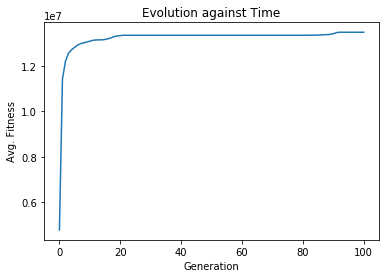

In [12]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(evolution['gen'], evolution['avg'])
ax.set_title('Evolution against Time')
ax.set_ylabel('Avg. Fitness')
ax.set_xlabel('Generation')
plt.show()

In [13]:
plt.close('all')

In the below figure we plot how often each item is selected as part of the solution set, we can se that almost all solutions in the final population are equal we name that Full Convergence.

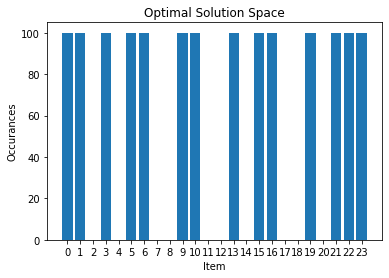

In [14]:
solutions_features = optimal_pop.sum(axis=0)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.bar(solutions_features.index, solutions_features)
ax.set_title('Optimal Solution Space')
ax.set_ylabel('Occurances')
ax.set_xlabel('Item')
ax.set_xticks(solutions_features.index)
plt.show()

Know we repeat our experiment  but with two objectives instead of one this time: **Maximizing** profit, while **Minimizing** weight. 

In [15]:
creator.create('FitnessMax', base.Fitness, weights=(1.0, -1.0))
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.pick, S)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)


/var/www/session/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/var/www/session/venv/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [16]:
def evaluate_multi_objective(indv):
  total_profit = 0
  total_weight = 0 
  for i,g in enumerate(indv):
    if g:
      total_weight += WEIGHTS[i]
      total_profit +=  PROFITS[i]
      
  if total_weight <= C:
    return (total_profit, total_weight)
  else:
    return (0, C)

In [17]:
toolbox.register('evaluate', evaluate_multi_objective)

In [18]:
pop = toolbox.population(n=100)
stats = tools.Statistics(lambda indv: indv.fitness.values)
stats.register('avg', np.mean, axis=0)
stats.register('std', np.std, axis=0)
stats.register('max', np.max, axis=0)
stats.register('min', np.min, axis=0)

history = algorithms.eaMuPlusLambda(pop, toolbox, mu=len(pop), lambda_=len(pop)*2, cxpb=0.5, mutpb=0.4, ngen=400, stats=stats, verbose=False)

In [19]:
evolution = pd.DataFrame(history[1])

In [20]:
optimal_pop = pd.DataFrame(history[0], index=None)

In [21]:
plt.close()

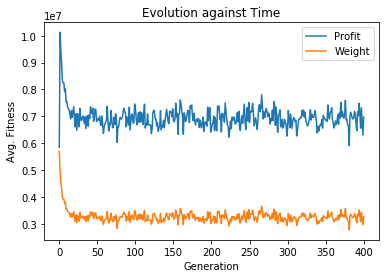

In [22]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(evolution['gen'], [fit[0] for fit in evolution['avg']], label='Profit')
ax.plot(evolution['gen'], [fit[1] for fit in evolution['avg']], label='Weight')
ax.set_title('Evolution against Time')
ax.set_ylabel('Avg. Fitness')
ax.set_xlabel('Generation')
ax.legend()
plt.show()

In [23]:
plt.close()

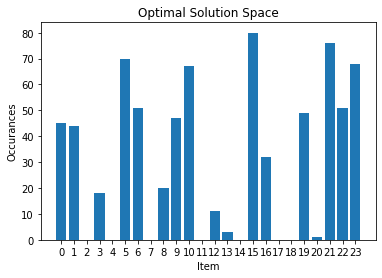

In [24]:
solutions_features = optimal_pop.sum(axis=0)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.bar(solutions_features.index, solutions_features)
ax.set_title('Optimal Solution Space')
ax.set_ylabel('Occurances')
ax.set_xlabel('Item')
ax.set_xticks(solutions_features.index)
plt.show()